In [1]:
import json

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# utility funtions for reading and preprocessing data


def read_data(filePath, indexCol=None):
    print(f"Reading {filePath}")
    dataRaw = pd.read_csv(filePath, index_col=indexCol)
    dataPreProcessed = preprocess_data(dataRaw)
    return dataPreProcessed

def preprocess_data(data):
    df = data.copy()
    # filter out data rows 
    dataRowsFilter = df['HSCode'].apply(is_data_row)
    combinedFilter = dataRowsFilter
    df = df[combinedFilter]
    # parse year col from str into int
    df = parse_year(df)
    return df

def is_data_row(x):
    # drop the column if HSCode is in (NaN, India's Total, '%Share')
    notHSCode = (np.NaN, "India's Total", '%Share')
    if x in notHSCode:
        return False
    else:
        return True
    

def parse_year(data): 
    # convert year from string to int '2019-2020' (str) ---> 2019 (int)
    try:
        with open('./yearCodes.json', 'r') as file: 
            yearCodes = json.load(file)
    except FileNotFoundError:
        raise FileNotFoundError('yearCodes.json file must be present in root directory')
        
    yearCodes = {value:key for key, value in yearCodes.items()}
        
    df = data.copy() 
    df['year'] = df['year'].apply(lambda x: yearCodes[x])
    df['year'] = df['year'].astype(np.int64)
    return df

In [3]:
# read imports and exports data
filePathExports = '210423_Exports.csv'
filePathImports = '210423_Imports.csv'
dataExports = read_data(filePathExports, indexCol=0)
dataImports = read_data(filePathImports, indexCol=0)

# aggregate imports and exports data by year
totalImports = dataImports.groupby('year').sum()
totalExports = dataExports.groupby('year').sum()

Reading 210423_Exports.csv
Reading 210423_Imports.csv


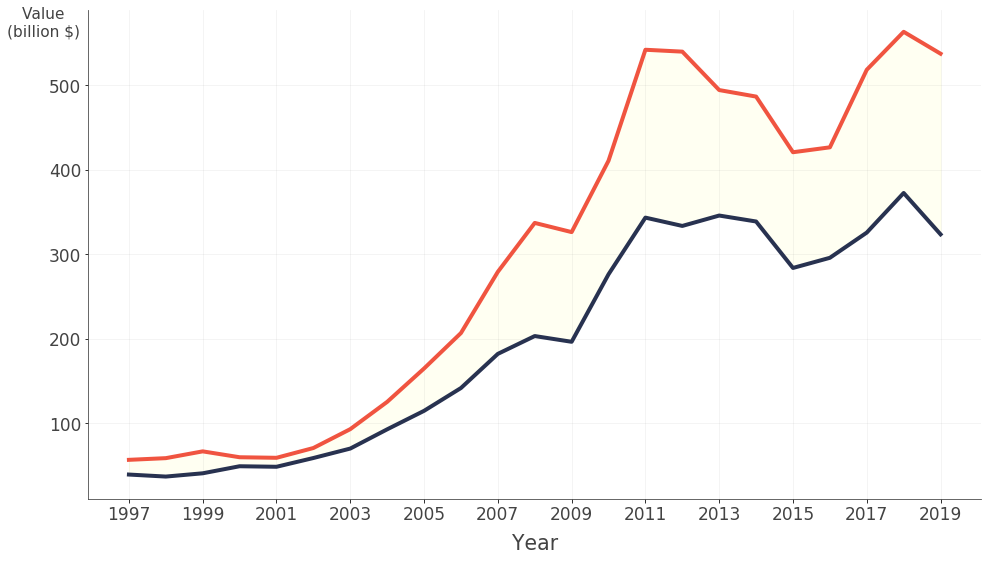

In [4]:
# generate final plot produced in Python

# plotting params
colorImports = '#f05440'
colorExports = '#283250'
colorGrid = '#bcbcbc'
colorGrey = '#434343'
linewidth = 4
labelSize = 17
labelpad=10
figLen = 16
figsize =  (figLen, (1080/1920)*figLen)


# skip last row of data (FY 2020 - 2021) since data is incomplete - avaialble only for Apr-Jan
xImports = totalImports.index[:-1] 
xExports = totalExports.index[:-1]
# USD million to billion 
yImports = totalImports.values[:-1]/1_000 
yExports = totalExports.values[:-1]/1_000 

# initalize figure and plot
plt.figure(figsize=figsize)
plt.plot(xImports, yImports, color=colorImports, linewidth=linewidth)
plt.plot(xExports, yExports, color=colorExports, linewidth=linewidth)
plt.fill_between(xImports, yImports.squeeze(), yExports.squeeze(), alpha=0.05, color='yellow')

# generate x ticks every two years
xticks = np.arange(xImports.min(), xImports.max() + 1, 2)

# adjust color, size, and orientation of ticks
plt.xticks(xticks, rotation=0, size=labelSize, color=colorGrey)
plt.yticks(size=labelSize, color=colorGrey)

# adjust axes label properties
plt.xlabel('Year', size=labelSize*1.2, labelpad=labelpad, color=colorGrey)
plt.ylabel('Value\n(billion $)', size=labelSize*0.9, labelpad=labelpad, color=colorGrey, rotation=0)

# move y-axis label to top right of figure to imporove readability
plt.gca().yaxis.set_label_coords(-0.05, 0.94)


# hide top and right spines
for item in ['top', 'right']:
    plt.gca().spines[item].set_visible(False)

# change color of 
for item in ['bottom', 'left']:
    plt.gca().spines[item].set_color(colorGrey)
    
# decrease grid alpha
plt.grid(True, color=colorGrey, alpha=0.07)

# plt.savefig('210429_ReWork_V1.png', bbox_inches='tight')